<a href="https://colab.research.google.com/github/LucasColas/CNN-VS-ViT/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet

## Import

### Download packages / dataset

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
!pip install wandb

### Import

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from medmnist import OCTMNIST  # Import the OCTMNIST dataset
import wandb
from sklearn.metrics import confusion_matrix
from PIL import Image

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Architecture

### ResidualBlock

In [4]:


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 activation=nn.ReLU(inplace=True), use_batchnorm=True):
        super(ResidualBlock, self).__init__()

        padding = kernel_size // 2  # To keep spatial dimensions constant

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                               padding=padding, bias=not use_batchnorm)
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                               padding=padding, bias=not use_batchnorm)
        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # Define the activation function
        self.activation = activation

        # If input and output channels differ, use a 1x1 conv to match dimensions
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        shortcut = self.shortcut(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.activation(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += shortcut
        out = self.activation(out)
        return out




### ResNet

In [5]:
class CustomResNet(nn.Module):
    def __init__(self,
                 in_channels=3,         # Input channels (e.g., 3 for RGB images)
                 num_blocks=4,          # Number of residual blocks
                 base_channels=64,      # Number of channels for the first block
                 kernel_size=3,         # Kernel size for convolutions
                 activation=nn.ReLU(inplace=True),  # Activation function
                 use_batchnorm=True,    # Whether to use BatchNorm
                 num_classes=10         # Number of classes for final output
                 ):
        super(CustomResNet, self).__init__()

        self.initial_conv = nn.Conv2d(in_channels, base_channels, kernel_size=kernel_size,
                                      padding=kernel_size//2, bias=not use_batchnorm)
        self.initial_bn = nn.BatchNorm2d(base_channels) if use_batchnorm else nn.Identity()
        self.activation = activation

        # Create a sequential container for residual blocks.
        layers = []
        # First block: input channels = base_channels, output channels = base_channels
        for _ in range(num_blocks):
            layers.append(ResidualBlock(base_channels, base_channels,
                                        kernel_size=kernel_size,
                                        activation=activation,
                                        use_batchnorm=use_batchnorm))
        self.residual_layers = nn.Sequential(*layers)

        # Global average pooling and a final linear classifier.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base_channels, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_bn(x)
        x = self.activation(x)

        x = self.residual_layers(x)

        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x



In [6]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = CustomResNet(
        in_channels=3,
        num_blocks=5,               # You can choose how many blocks
        base_channels=64,
        kernel_size=3,              # Kernel size can be adjusted
        activation=nn.LeakyReLU(0.1, inplace=True),  # You can choose any activation
        use_batchnorm=True,         # Toggle batch normalization
        num_classes=1000            # For example, for ImageNet classification
    )

model = model.to(device)
print(model)


dummy_input = torch.randn(1, 3, 224, 224).to(device)
output = model(dummy_input)
print("Output shape:", output.shape)

Using device: cuda
CustomResNet(
  (initial_conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

## Preprocessing

Train dataset size: 97477
Test dataset size: 1000


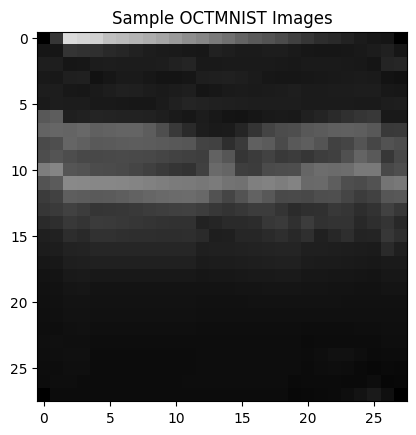

torch.Size([1, 1])


In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),      # Randomly rotate images by +/- 10 degrees
    transforms.ToTensor(),
    # Normalize for a single channel (grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5])
])
# Download the OCTMNIST dataset.
train_dataset = OCTMNIST(split='train', transform=transform_train, download=True)
test_dataset  = OCTMNIST(split='test', transform=transform_train, download=True)

print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))

# Create data loaders.
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Visualize a few training samples
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:1]), title="Sample OCTMNIST Images")
print(labels[:1].shape)


## Training

In [12]:
def train_model(model, config, run_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    num_epochs = config["num_epochs"]

    # For logging the confusion matrix at the end of training
    all_test_targets = []
    all_test_preds = []

    for epoch in range(num_epochs):
        # --------------------
        # Training Phase
        # --------------------
        model.train()
        running_loss = 0.0
        train_loss_epoch = 0.0
        train_correct = 0
        train_total = 0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.squeeze().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loss_epoch += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            if i % 20 == 19:  # Log every 20 mini-batches
                avg_loss = running_loss / 20
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {avg_loss:.4f}")
                # Log training loss with epoch as x-axis value
                wandb.log({"epoch": epoch+1, "train_loss": avg_loss})
                running_loss = 0.0

        avg_train_loss = train_loss_epoch / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # --------------------
        # Evaluation Phase
        # --------------------
        model.eval()
        test_loss = 0.0
        test_loss_epoch = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)

                test_loss_epoch += loss.item()
                test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += targets.size(0)
                test_correct += (predicted == targets).sum().item()

                # Accumulate predictions and true labels for confusion matrix
                all_test_targets.extend(targets.cpu().numpy())
                all_test_preds.extend(predicted.cpu().numpy())



        avg_test_loss = test_loss_epoch / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

        wandb.log({
            "epoch": epoch + 1,
            "train_accuracy": train_accuracy,
            "test_accuracy": test_accuracy,
        })
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | Test Loss: {avg_test_loss:.4f} | Test Acc: {test_accuracy:.2f}%")

    # --------------------
    # Confusion Matrix Logging
    # --------------------
    class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]  # Adjust if necessary
    cm = confusion_matrix(all_test_targets, all_test_preds)
    wandb.log({"confusion_matrix": wandb.plot.confusion_matrix(
                probs=None,
                y_true=np.array(all_test_targets),
                preds=np.array(all_test_preds),
                class_names=class_names)})

    # Optionally, log a matplotlib figure of the confusion matrix.
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(len(class_names)),
           yticks=np.arange(len(class_names)),
           xticklabels=class_names,
           yticklabels=class_names,
           title="Confusion Matrix",
           ylabel="True label",
           xlabel="Predicted label")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    wandb.log({"confusion_matrix_fig" + run_name: fig})
    plt.close(fig)

In [ ]:
!wandb online

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 5,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 5,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}

# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name='test',
):
    # Create the model with custom configuration
    model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
    print(model)

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, "test")

wandb.finish()

## Experiments



### Without data augmentation

In [ ]:
!wandb online

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 20,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 18,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}

# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name='resnet-18',
):
    # Create the model with custom configuration
    model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
    print(model)

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, "simple resnet")

wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

epoch,▁▁▁▁▂▂▂▂▂▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇████
test_accuracy per epoch,▁▅▇▆▇▅▆▇▅▇▆▇▇█▇▆▇▅▄█
train_accuracy per epoch,▁▄▅▆▆▆▇▇▇▇▇▇▇███████
train_loss,█▅▅▅▄▂▄▃▄▂▃▃▂▄▃▂▃▃▂▂▃▂▃▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▂
epoch,20
test_accuracy per epoch,78.8
train_accuracy per epoch,91.75395
train_loss,0.25645


### With data augmentation

100%|██████████| 54.9M/54.9M [00:04<00:00, 13.4MB/s]


Raw Train dataset size: 97477
Test dataset size: 1000
Augmented Train dataset size: 974770


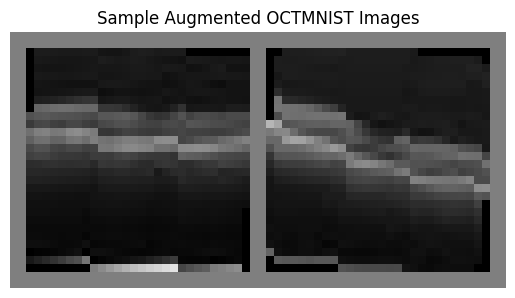

Labels: tensor([[3],
        [3]])


In [ ]:
# Download the OCTMNIST dataset without transforms to get raw PIL images.
raw_train_dataset = OCTMNIST(split='train', transform=None, download=True)
test_dataset  = OCTMNIST(split='test', transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
]), download=True)

print("Raw Train dataset size:", len(raw_train_dataset))
print("Test dataset size:", len(test_dataset))

# Define an augmentation transform.
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Random horizontal flip.
    transforms.RandomRotation(10),        # Random rotation of +/- 10 degrees.
    transforms.ToTensor(),
    # Normalize for a single channel (grayscale)
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Augment every image in the raw_train_dataset 10 times.
augmented_images = []
augmented_labels = []
n_augmented_images = 10
for i in range(len(raw_train_dataset)):
    img, label = raw_train_dataset[i]
    for _ in range(n_augmented_images):
        aug_img = augmentation_transform(img)
        augmented_images.append(aug_img)
        augmented_labels.append(label)

print("Augmented Train dataset size:", len(augmented_images))
# Convert lists into a dataset.
augmented_train_dataset = TensorDataset(
    torch.stack(augmented_images),
    torch.from_numpy(np.array(augmented_labels))
)

# Create data loaders.
batch_size = 64
train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# (Optional) Visualize a few augmented training samples.
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Display the first two images from the augmented training loader.
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:2]), title="Sample Augmented OCTMNIST Images")
print("Labels:", labels[:2])

#### Resnet-18

In [ ]:
!wandb online

name = "resnet-18 with data aug"

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 3,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 18,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}

# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name=name,
):
    # Create the model with custom configuration
    model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
    print(model)

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, name)

wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

epoch,▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅██████████████
test_accuracy per epoch,█▄▁
train_accuracy per epoch,▁▆█
train_loss,█▄▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch,3
test_accuracy per epoch,74.1
train_accuracy per epoch,92.48838
train_loss,0.18269


#### Resnet-18 with 1 epoch

In [ ]:
!wandb online

name = "resnet-18 with data aug (1 epoch)"

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 1,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 18,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}

# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name=name,
):
    # Create the model with custom configuration
    model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
    print(model)

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, name)

wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy per epoch,▁
train_accuracy per epoch,▁
train_loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,1
test_accuracy per epoch,77.8
train_accuracy per epoch,88.2956
train_loss,0.27521


#### Resnet-3

In [ ]:
!wandb online

name = "resnet-3 with data aug"

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 5,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 3,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}



W&B online. Running your script from this directory will now sync to the cloud.


In [ ]:
# Create the model with custom configuration
model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
print(model)

print("number of parameters : ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name=name,
):

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, name)

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukyoda-13 (lukyoda-13-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/5], Step [20/15231], Loss: 1.0101
Epoch [1/5], Step [40/15231], Loss: 0.8249
Epoch [1/5], Step [60/15231], Loss: 0.7395
Epoch [1/5], Step [80/15231], Loss: 0.6796
Epoch [1/5], Step [100/15231], Loss: 0.7375
Epoch [1/5], Step [120/15231], Loss: 0.7404
Epoch [1/5], Step [140/15231], Loss: 0.6529
Epoch [1/5], Step [160/15231], Loss: 0.6288
Epoch [1/5], Step [180/15231], Loss: 0.6157
Epoch [1/5], Step [200/15231], Loss: 0.6088
Epoch [1/5], Step [220/15231], Loss: 0.6501
Epoch [1/5], Step [240/15231], Loss: 0.6224
Epoch [1/5], Step [260/15231], Loss: 0.6017
Epoch [1/5], Step [280/15231], Loss: 0.6473
Epoch [1/5], Step [300/15231], Loss: 0.5842
Epoch [1/5], Step [320/15231], Loss: 0.5249
Epoch [1/5], Step [340/15231], Loss: 0.6389
Epoch [1/5], Step [360/15231], Loss: 0.5811
Epoch [1/5], Step [380/15231], Loss: 0.5950
Epoch [1/5], Step [400/15231], Loss: 0.5955
Epoch [1/5], Step [420/15231], Loss: 0.5359
Epoch [1/5], Step [440/15231], Loss: 0.5849
Epoch [1/5], Step [460/15231], Loss:

epoch,▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆████████
test_accuracy per epoch,▅█▆█▁
train_accuracy per epoch,▁▅▆▇█
train_loss,█▆▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▁▂▂▁▂▂▁▁▁▁▁▂
epoch,5
test_accuracy per epoch,72.5
train_accuracy per epoch,92.79902
train_loss,0.19068


In [ ]:
!wandb online

name = "resnet-3 with data aug (2 epochs)"

# Configuration dictionary for wandb
config = {
    "in_channels": 1,
    "num_epochs": 2,            # Adjust number of epochs as necessary
    "lr": 0.001,                # Learning rate
    "batch_size": 64,           # Batch size (should match your DataLoader)
    "num_blocks": 3,            # Number of residual blocks in the network
    "base_channels": 64,        # Number of filters in the first block
    "kernel_size": 3,           # Kernel size for convolutions
    "activation": "LeakyReLU",  # Name of the activation function
    "use_batchnorm": True,      # Whether to use batch normalization
    "num_classes": 4            # OCTMNIST has 4 classes
}

# Create the model with custom configuration
model = CustomResNet(
        in_channels=config['in_channels'],  # OCTMNIST images are single-channel if you have preprocessed accordingly
        num_blocks=config["num_blocks"],
        base_channels=config["base_channels"],
        kernel_size=config["kernel_size"],
        activation=nn.LeakyReLU(0.1, inplace=True),
        use_batchnorm=config["use_batchnorm"],
        num_classes=config["num_classes"]
    )
print(model)

print("number of parameters : ")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

# Initialize wandb run and train the model
with wandb.init(
    config=config,
    project='CNN VS ViT',   # Title of your project
    group='Test',           # Group name for your run
    save_code=True,
    name=name,
):

    # Train the model (train_loader and test_loader should be defined before)
    train_model(model, config, name)

wandb.finish()

W&B online. Running your script from this directory will now sync to the cloud.
CustomResNet(
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (initial_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  (residual_layers): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): LeakyReLU(negative_slope=0.1, inplace=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1

Epoch [1/2], Step [20/15231], Loss: 1.0435
Epoch [1/2], Step [40/15231], Loss: 0.8554
Epoch [1/2], Step [60/15231], Loss: 0.7751
Epoch [1/2], Step [80/15231], Loss: 0.7318
Epoch [1/2], Step [100/15231], Loss: 0.7532
Epoch [1/2], Step [120/15231], Loss: 0.7272
Epoch [1/2], Step [140/15231], Loss: 0.7388
Epoch [1/2], Step [160/15231], Loss: 0.6885
Epoch [1/2], Step [180/15231], Loss: 0.6293
Epoch [1/2], Step [200/15231], Loss: 0.6348
Epoch [1/2], Step [220/15231], Loss: 0.6612
Epoch [1/2], Step [240/15231], Loss: 0.6682
Epoch [1/2], Step [260/15231], Loss: 0.6389
Epoch [1/2], Step [280/15231], Loss: 0.5653
Epoch [1/2], Step [300/15231], Loss: 0.6137
Epoch [1/2], Step [320/15231], Loss: 0.5874
Epoch [1/2], Step [340/15231], Loss: 0.6039
Epoch [1/2], Step [360/15231], Loss: 0.5826
Epoch [1/2], Step [380/15231], Loss: 0.5823
Epoch [1/2], Step [400/15231], Loss: 0.5901
Epoch [1/2], Step [420/15231], Loss: 0.5533
Epoch [1/2], Step [440/15231], Loss: 0.6158
Epoch [1/2], Step [460/15231], Loss:

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████████████
test_accuracy per epoch,▁█
train_accuracy per epoch,▁█
train_loss,█▆▆▄▄▄▄▂▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▂▂▁▂▂
epoch,2
test_accuracy per epoch,77.3
train_accuracy per epoch,90.5431
train_loss,0.23558


## Best architecture

### Grid search

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# ---------------------------
# Data Loading and Augmentation Function
# ---------------------------
def create_dataloaders(n_augmented_images, batch_size):
    # Download the OCTMNIST dataset without transforms to get raw PIL images.
    raw_train_dataset = OCTMNIST(split='train', transform=None, download=True)
    test_dataset = OCTMNIST(split='test', transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]), download=True)

    print("Raw Train dataset size:", len(raw_train_dataset))
    print("Test dataset size:", len(test_dataset))

    # Define the augmentation transform.
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Augment every image in the raw training dataset.
    augmented_images = []
    augmented_labels = []
    for i in range(len(raw_train_dataset)):
        img, label = raw_train_dataset[i]
        for _ in range(n_augmented_images):
            aug_img = augmentation_transform(img)
            augmented_images.append(aug_img)
            augmented_labels.append(label)

    print("Augmented Train dataset size:", len(augmented_images))
    augmented_train_dataset = TensorDataset(
        torch.stack(augmented_images),
        torch.from_numpy(np.array(augmented_labels))
    )

    # Create DataLoaders.
    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

# ---------------------------
# Visualization Function (Optional)
# ---------------------------
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# ---------------------------
# Training Function with Checkpoint Saving and Print Statements
# ---------------------------
def train_model(model, config, run_name, train_loader, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    num_epochs = config["num_epochs"]

    # Create checkpoint directory if it doesn't exist.
    checkpoint_dir = "checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    for epoch in range(num_epochs):
        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

        # Training phase.
        model.train()
        train_loss_epoch = 0.0
        train_correct = 0
        train_total = 0

        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.squeeze().to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss_epoch += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

            print(f"[Batch {i+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

        avg_train_loss = train_loss_epoch / len(train_loader)
        train_accuracy = 100 * train_correct / train_total

        # Evaluation phase.
        model.eval()
        test_loss_epoch = 0.0
        test_correct = 0
        test_total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.squeeze().to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss_epoch += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                test_total += targets.size(0)
                test_correct += (predicted == targets).sum().item()

        avg_test_loss = test_loss_epoch / len(test_loader)
        test_accuracy = 100 * test_correct / test_total

        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.2f}%")
        print(f"Epoch [{epoch+1}/{num_epochs}] | Test  Loss: {avg_test_loss:.4f} | Test  Acc: {test_accuracy:.2f}%")

        # Save model checkpoint.
        checkpoint_path = os.path.join(checkpoint_dir, f"{run_name}_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")

# ---------------------------
# Grid Search Execution
# ---------------------------
if __name__ == "__main__":
    # Define grid search parameter lists.
    grid_search_params = {
        "num_epochs": [3, 5],
        "lr": [0.001, 0.0005],
        "batch_size": [32, 64],
        "num_blocks": [3, 5],
        "base_channels": [32, 64],
        "kernel_size": [3, 5],
        "n_augmented_images": [5, 10]
    }

    # Iterate over every combination of the grid search parameters.
    for num_epochs in grid_search_params["num_epochs"]:
        for lr in grid_search_params["lr"]:
            for bs in grid_search_params["batch_size"]:
                for num_blocks in grid_search_params["num_blocks"]:
                    for base_channels in grid_search_params["base_channels"]:
                        for kernel_size in grid_search_params["kernel_size"]:
                            for n_aug in grid_search_params["n_augmented_images"]:
                                # Define configuration for this run.
                                config = {
                                    "in_channels": 1,
                                    "num_epochs": num_epochs,
                                    "lr": lr,
                                    "batch_size": bs,
                                    "num_blocks": num_blocks,
                                    "base_channels": base_channels,
                                    "kernel_size": kernel_size,
                                    "activation": "LeakyReLU",  # Can be logged or used to choose activation.
                                    "use_batchnorm": True,
                                    "num_classes": 4
                                }

                                run_name = (f"epochs{num_epochs}_lr{lr}_bs{bs}_blocks{num_blocks}"
                                            f"_base{base_channels}_kernel{kernel_size}_aug{n_aug}")
                                print(f"\nStarting run: {run_name}")

                                # Create data loaders for this configuration.
                                train_loader, test_loader = create_dataloaders(n_augmented_images=n_aug, batch_size=bs)

                                # (Optional) Visualize a few augmented training samples.
                                dataiter = iter(train_loader)
                                images, labels = next(dataiter)
                                imshow(torchvision.utils.make_grid(images[:2]), title=f"Sample Augmented OCTMNIST Images ({run_name})")
                                print("Labels:", labels[:2])

                                # Create a new model instance.
                                model = CustomResNet(
                                    in_channels=config['in_channels'],
                                    num_blocks=config["num_blocks"],
                                    base_channels=config["base_channels"],
                                    kernel_size=config["kernel_size"],
                                    activation=nn.LeakyReLU(0.1, inplace=True),
                                    use_batchnorm=config["use_batchnorm"],
                                    num_classes=config["num_classes"]
                                )
                                print(model)

                                # Train the model with the current configuration.
                                train_model(model, config, run_name, train_loader, test_loader)

